In [ ]:
# ref: https://theiconic.tech/implementing-the-youtube-recommendations-paper-in-tensorflow-part-1-d1e1299d5622
from urllib.request import urlretrieve
import zipfile
import pandas as pd
import numpy as np
import tensorflow as tf
import datetime
import os

In [ ]:
# Get the data from Movielens website
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))

#Process the dataset for movies, users,ratings and genre
# Load each data set (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western",
]

movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols

movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Since the ids start at 1, we shift them to start at 0.
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


In [ ]:
#Get all the genres for a movie
genre_occurences = movies[genre_cols].sum().to_dict()
genres_encoded = {x: i for i, x in enumerate(genre_cols)}

def get_genres(movies, genres):
  def get_all_genres(gs):
    active = [str(genres_encoded[genre]) for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return '0'
    return ','.join((active))
  movies['all_genres'] = [
      get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

get_genres(movies, genre_cols)

In [ ]:
# movie info
movies.head(3)

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,all_genres
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1995,"3,4,5"
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1995,"1,2,16"
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1995,16


In [ ]:
# rating details
rating_details_sample = ratings.merge(movies, on='movie_id').merge(users, on='user_id')
print(rating_details_sample.shape)
rating_details_sample.head(3)

(100000, 33)


,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,all_genres,age,sex,occupation,zip_code
0,195,241,3.0,881250949,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1997,5,49,M,writer,55105
1,195,256,2.0,881251577,Men in Black (1997),04-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Men+in+Black+...,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1997,"1,2,5,15",49,M,writer,55105
2,195,110,4.0,881251793,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Truth%20About...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1996,"5,14",49,M,writer,55105


In [ ]:
rating_details_sample['user_id'] = rating_details_sample['user_id'].astype(int)
rating_details_sample['movie_id'] = rating_details_sample['movie_id'].astype(int)
rating_details_sample = rating_details_sample.set_index(['user_id','unix_timestamp']).sort_index()
rating_details_sample = rating_details_sample.reset_index()

In [ ]:
# Get the like and dislike movie list
rating_details_sample['movie_type'] = np.where(rating_details_sample['rating'] >=3, 'like','dislike')
rating_details_sample['movie_name'] = rating_details_sample['title'].str[:-6]
rating_details_sample.head(3)

,user_id,unix_timestamp,movie_id,rating,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,all_genres,age,sex,occupation,zip_code,movie_type,movie_name
0,0,874965478,171,5.0,"Empire Strikes Back, The (1980)",01-Jan-1980,NaN,http://us.imdb.com/M/title-exact?Empire%20Stri...,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,1980,"1,2,8,14,15,17",24,M,technician,85711,like,"Empire Strikes Back, The"
1,0,874965478,167,5.0,Monty Python and the Holy Grail (1974),01-Jan-1974,NaN,http://us.imdb.com/M/title-exact?Monty%20Pytho...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1974,5,24,M,technician,85711,like,Monty Python and the Holy Grail
2,0,874965518,164,5.0,Jean de Florette (1986),01-Jan-1986,NaN,http://us.imdb.com/M/title-exact?Jean%20de%20F...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1986,8,24,M,technician,85711,like,Jean de Florette


In [ ]:
user_ids = rating_details_sample["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

movie_ids = rating_details_sample["movie_id"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

title_ids = rating_details_sample["movie_name"].unique().tolist()
title2title_encoded = {x: i for i, x in enumerate(title_ids)}
title_encoded2title = {i: x for i, x in enumerate(title_ids)}

rating_details_sample["user"] = rating_details_sample["user_id"].map(user2user_encoded)
rating_details_sample["movie"] = rating_details_sample["movie_id"].map(movie2movie_encoded)
rating_details_sample["title_d"] = rating_details_sample["movie_name"].map(title2title_encoded)

In [ ]:
sample_data = rating_details_sample[['user','occupation','sex']]
sample_data = sample_data.reset_index()

In [ ]:
rating_details_sample["movie"].max()

1681

In [ ]:
movie_list = rating_details_sample.groupby(['user','movie_type'])['movie'].apply(list).reset_index()
title_list = rating_details_sample.groupby(['user'])['title_d'].apply(list).reset_index()
genre_list = rating_details_sample.groupby(['user'])['all_genres'].unique().apply(list).reset_index()

In [ ]:
# Get the unique set of genre for all the users
genre_list['all_genres']=genre_list['all_genres'].apply(lambda x: list(set(','.join(x))) ) 
genre_list['all_genres']=genre_list['all_genres'].apply(lambda x:[ x for x in x if x.isdigit() ])

In [ ]:
user_video_list = movie_list.pivot(index='user', columns='movie_type', values='movie').reset_index()
user_video_list.fillna(rating_details_sample["movie"].max()+1, inplace=True)

In [ ]:
sample_data = sample_data.drop('index',axis=1)

In [ ]:
sample_data =sample_data.drop_duplicates()

In [ ]:
sample_data.head()

,user,occupation,sex
0,0,technician,M
272,1,other,F
334,2,writer,M
388,3,technician,M
412,4,other,F


In [ ]:
user_final_list =pd.merge(user_video_list,title_list, how = 'left')
user_title_list1 = pd.merge(user_final_list,genre_list, how ='left')
user_title_list = pd.merge(user_title_list1,sample_data, how ='left')
user_title_list1.head(3)

,user,dislike,like,title_d,all_genres
0,0,"[31, 32, 33, 35, 36, 55, 71, 81, 97, 99, 107, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 7, 6, 2, 5, 3, 1, 4, 8, 9]"
1,1,"[279, 298, 130, 313, 314]","[272, 250, 273, 274, 275, 276, 277, 278, 280, ...","[271, 249, 272, 273, 274, 275, 276, 277, 278, ...","[0, 7, 6, 2, 5, 3, 8, 4, 1, 9]"
2,2,"[302, 317, 309, 318, 275, 250, 321, 253, 322, ...","[316, 125, 278, 319, 320, 324, 325, 326, 328, ...","[300, 314, 315, 307, 14, 277, 316, 317, 318, 2...","[0, 6, 7, 2, 5, 3, 1, 8, 4]"


In [ ]:
user_title_list['like'] =user_title_list['like'].apply(lambda x: x if type(x) is list else [x])
user_title_list['dislike'] =user_title_list['dislike'].apply(lambda x: x if type(x) is list else [x])
user_title_list['predict_labels'] = user_title_list['like'].apply(lambda x: (x[-1]))
user_title_list['like']=user_title_list['like'].apply(lambda x: (x[:-1]))

In [ ]:
pd.DataFrame(user_title_list[['user','dislike','like','title_d','all_genres','predict_labels']]).head(3)

,user,dislike,like,title_d,all_genres,predict_labels
0,0,"[31, 32, 33, 35, 36, 55, 71, 81, 97, 99, 107, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 7, 6, 2, 5, 3, 1, 4, 8, 9]",269
1,1,"[279, 298, 130, 313, 314]","[272, 250, 273, 274, 275, 276, 277, 278, 280, ...","[271, 249, 272, 273, 274, 275, 276, 277, 278, ...","[0, 7, 6, 2, 5, 3, 8, 4, 1, 9]",315
2,2,"[302, 317, 309, 318, 275, 250, 321, 253, 322, ...","[316, 125, 278, 319, 320, 324, 325, 326, 328, ...","[300, 314, 315, 307, 14, 277, 316, 317, 318, 2...","[0, 6, 7, 2, 5, 3, 1, 8, 4]",354


In [ ]:
user_title_list_e = user_title_list[(user_title_list.user >= 1) & (user_title_list.user <= 500)]
user_title_list.shape

(943, 8)

In [ ]:
# Learning parameters
EMBEDDING_DIMS = 16
DENSE_UNITS = 64
DROPOUT_PCT = 0.0
ALPHA = 0.0
NUM_CLASSES=rating_details_sample["movie"].max()+2
LEARNING_RATE = 0.003 

In [ ]:
class MaskedEmbeddingsAggregatorLayer(tf.keras.layers.Layer):
    def __init__(self, agg_mode='sum', **kwargs):
        super(MaskedEmbeddingsAggregatorLayer, self).__init__(**kwargs)

        if agg_mode not in ['sum', 'mean']:
            raise NotImplementedError('mode {} not implemented!'.format(agg_mode))
        self.agg_mode = agg_mode
    
    @tf.function
    def call(self, inputs, mask=None):
        masked_embeddings = tf.ragged.boolean_mask(inputs, mask)
        if self.agg_mode == 'sum':
            aggregated =  tf.reduce_sum(masked_embeddings, axis=1)
        elif self.agg_mode == 'mean':
            aggregated = tf.reduce_mean(masked_embeddings, axis=1)
        
        return aggregated
    
    def get_config(self):
        # this is used when loading a saved model that uses a custom layer
        return {'agg_mode': self.agg_mode}

In [ ]:
class L2NormLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(L2NormLayer, self).__init__(**kwargs)
    
    @tf.function
    def call(self, inputs, mask=None):
        if mask is not None:
            inputs = tf.ragged.boolean_mask(inputs, mask).to_tensor()
        return tf.math.l2_normalize(inputs, axis=-1)

    def compute_mask(self, inputs, mask):
        return mask

In [ ]:
#---inputs
input_title = tf.keras.Input(shape=(None, ), name='movie_name')
inp_video_liked = tf.keras.layers.Input(shape=(None,), name='like')
inp_video_disliked = tf.keras.layers.Input(shape=(None,), name='dislike')
input_genre = tf.keras.Input(shape=(None, ), name='genre')

#--- layers
features_embedding_layer = tf.keras.layers.Embedding(input_dim=NUM_CLASSES, output_dim=EMBEDDING_DIMS, 
                                            mask_zero=True, trainable=True, name='features_embeddings')
labels_embedding_layer = tf.keras.layers.Embedding(input_dim=NUM_CLASSES, output_dim=EMBEDDING_DIMS, 
                                            mask_zero=True, trainable=True, name='labels_embeddings')

# aggregate embeddings
avg_embeddings = MaskedEmbeddingsAggregatorLayer(agg_mode='mean', name='aggregate_embeddings')

dense_1 = tf.keras.layers.Dense(units=DENSE_UNITS, name='dense_1')
dense_2 = tf.keras.layers.Dense(units=DENSE_UNITS, name='dense_2')
dense_3 = tf.keras.layers.Dense(units=DENSE_UNITS, name='dense_3')
l2_norm_1 = L2NormLayer(name='l2_norm_1')

dense_output = tf.keras.layers.Dense(NUM_CLASSES, activation=tf.nn.softmax, name='dense_output')

#--- features
features_embeddings = features_embedding_layer(input_title)
l2_norm_features = l2_norm_1(features_embeddings)
avg_features = avg_embeddings(l2_norm_features)

labels_liked_embeddings = labels_embedding_layer(inp_video_liked)
l2_norm_liked = l2_norm_1(labels_liked_embeddings)
avg_liked = avg_embeddings(l2_norm_liked)

labels_disliked_embeddings = labels_embedding_layer(inp_video_disliked)
l2_norm_disliked = l2_norm_1(labels_disliked_embeddings)
avg_disliked = avg_embeddings(l2_norm_disliked)

labels_genre_embeddings = labels_embedding_layer(input_genre)
l2_norm_genre = l2_norm_1(labels_genre_embeddings)
avg_genre = avg_embeddings(l2_norm_genre)

concat_inputs = tf.keras.layers.Concatenate(axis=1)([avg_features,
                                                     avg_liked,
                                                     avg_disliked,
                                                     avg_genre
                                                     ])
# Dense Layers
dense_1_features = dense_1(concat_inputs)
dense_1_relu = tf.keras.layers.ReLU(name='dense_1_relu')(dense_1_features)
dense_1_batch_norm = tf.keras.layers.BatchNormalization(name='dense_1_batch_norm')(dense_1_relu)

dense_2_features = dense_2(dense_1_relu)
dense_2_relu = tf.keras.layers.ReLU(name='dense_2_relu')(dense_2_features)
#dense_2_batch_norm = tf.keras.layers.BatchNormalization(name='dense_2_batch_norm')(dense_2_relu)

dense_3_features = dense_3(dense_2_relu)
dense_3_relu = tf.keras.layers.ReLU(name='dense_3_relu')(dense_3_features)
dense_3_batch_norm = tf.keras.layers.BatchNormalization(name='dense_3_batch_norm')(dense_3_relu)
outputs = dense_output(dense_3_batch_norm)

#Optimizer
optimiser = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

#--- prep model
model = tf.keras.models.Model(
    inputs=[input_title, inp_video_liked, 
            inp_video_disliked
            ,input_genre
            ],
    outputs=[outputs]
)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy')

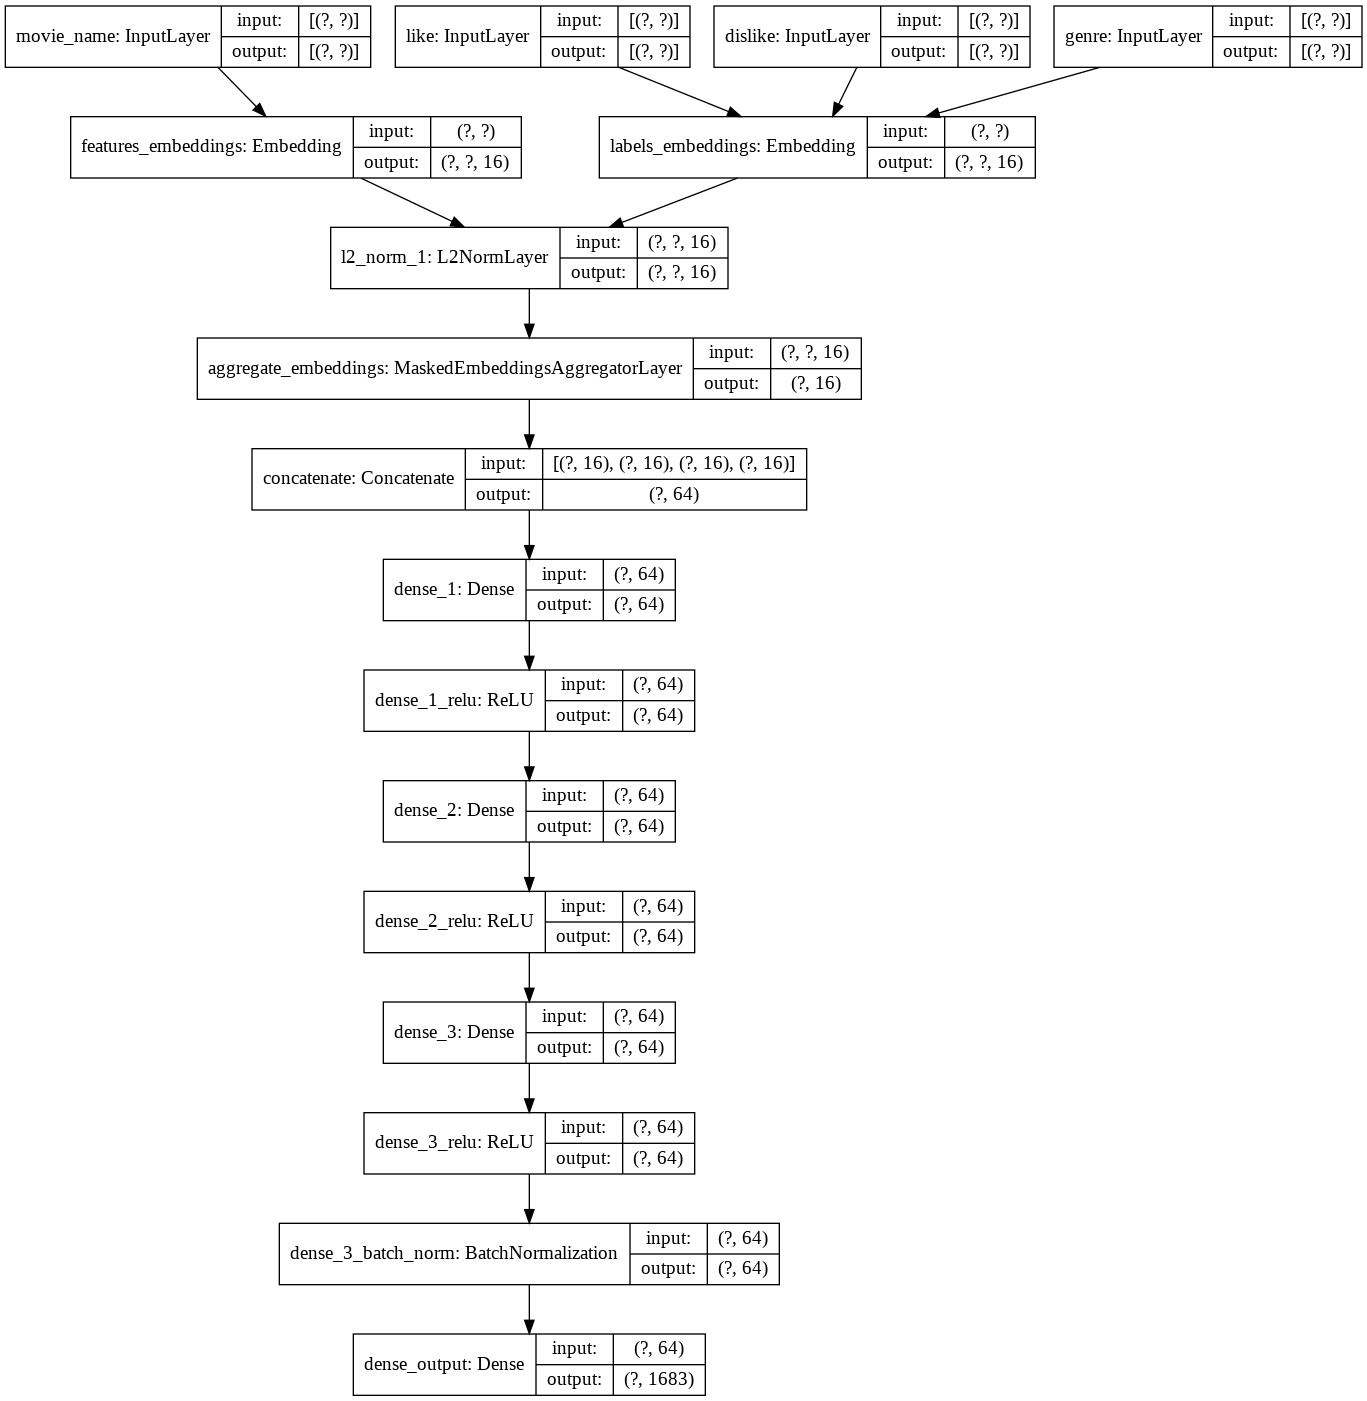

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.fit([tf.keras.preprocessing.sequence.pad_sequences(user_title_list_e['title_d']),
           tf.keras.preprocessing.sequence.pad_sequences(user_title_list_e['like']),
           tf.keras.preprocessing.sequence.pad_sequences(user_title_list_e['dislike']),
            tf.keras.preprocessing.sequence.pad_sequences(user_title_list_e['all_genres'])
           ],
           user_title_list_e['predict_labels'].values,callbacks=[tensorboard_callback],
           steps_per_epoch=1, epochs=1000,verbose=1)

Epoch 1/1000
1/1 [==============================] - 0s 31ms/step - loss: 7.4342
Epoch 2/1000
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1/1 [==============================] - 0s 30ms/step - loss: 7.4267
Epoch 3/1000
1/1 [==============================] - 0s 29ms/step - loss: 7.4212
Epoch 4/1000
1/1 [==============================] - 0s 28ms/step - loss: 7.4116
Epoch 5/1000
1/1 [==============================] - 0s 29ms/step - loss: 7.4078
Epoch 6/1000
1/1 [==============================] - 0s 30ms/step - loss: 7.3995
Epoch 7/1000
1/1 [==============================] - 0s 30ms/step - loss: 7.3916
Epoch 8/1000
1/1 [==============================] - 0s 34ms/step - loss: 7.3782
Epoch 9/1000
1/1 [==============================] - 0s 29ms/step - loss: 7.3665
Epoch 10/1000
1/1 [==============================] - 0s 38ms/step - loss: 7.3588
Epoch 11/1000
1/1 [==============================] - 0s 29ms/step - loss: 7.3435
Epoch 12/1000
1/1 [===========================

In [ ]:
user_list_1 = user_title_list[user_title_list.user>600]
user_list_1.head(3)

,user,dislike,like,title_d,all_genres,occupation,sex,predict_labels
601,601,[326],"[309, 786, 870, 361, 298, 308, 457, 716, 127, ...","[307, 777, 860, 358, 296, 306, 324, 454, 708, ...","[6, 7, 2, 5, 3, 1, 8, 4]",other,F,43
602,602,"[254, 179, 295, 936, 136, 405, 152]","[249, 243, 17, 184, 176, 153, 379, 412, 376, 2...","[248, 242, 253, 17, 183, 175, 152, 178, 376, 4...","[0, 7, 6, 2, 5, 3, 1, 4, 8]",programmer,M,921
603,603,"[63, 87, 82, 423, 268, 158, 426, 653]","[72, 8, 56, 132, 241, 27, 163, 148, 652, 372, ...","[72, 8, 56, 131, 63, 240, 27, 87, 162, 147, 64...","[6, 7, 2, 5, 1, 8, 4, 9]",educator,M,657


In [ ]:
predict = model.predict([tf.keras.preprocessing.sequence.pad_sequences(user_list_1['title_d']),
          tf.keras.preprocessing.sequence.pad_sequences(user_list_1['like']),
          tf.keras.preprocessing.sequence.pad_sequences(user_list_1['dislike']),
          tf.keras.preprocessing.sequence.pad_sequences(user_list_1['all_genres'])
          ])

predictions = np.array([np.argmax(a) for a in predict])

In [ ]:
user_list_1['predicted_label'] = predictions
user_list_1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,user,dislike,like,title_d,all_genres,occupation,sex,predict_labels,predicted_label
601,601,[326],"[309, 786, 870, 361, 298, 308, 457, 716, 127, ...","[307, 777, 860, 358, 296, 306, 324, 454, 708, ...","[6, 7, 2, 5, 3, 1, 8, 4]",other,F,43,250
602,602,"[254, 179, 295, 936, 136, 405, 152]","[249, 243, 17, 184, 176, 153, 379, 412, 376, 2...","[248, 242, 253, 17, 183, 175, 152, 178, 376, 4...","[0, 7, 6, 2, 5, 3, 1, 4, 8]",programmer,M,921,594
603,603,"[63, 87, 82, 423, 268, 158, 426, 653]","[72, 8, 56, 132, 241, 27, 163, 148, 652, 372, ...","[72, 8, 56, 131, 63, 240, 27, 87, 162, 147, 64...","[6, 7, 2, 5, 1, 8, 4, 9]",educator,M,657,6
604,604,"[309, 340, 11, 539, 81, 53, 1042, 930, 39, 610...","[272, 171, 302, 349, 275, 298, 758, 276, 761, ...","[271, 170, 307, 300, 347, 274, 296, 338, 749, ...","[0, 7, 6, 2, 5, 3, 8, 4, 1]",engineer,M,481,31
605,605,"[918, 298, 362, 1043, 201, 114, 71, 219, 501, ...","[275, 539, 336, 17, 256, 21, 721, 10, 9, 131, ...","[274, 534, 334, 17, 255, 21, 713, 10, 9, 130, ...","[0, 6, 7, 2, 5, 3, 1, 8, 4, 9]",programmer,M,1181,9
...,...,...,...,...,...,...,...,...,...
938,938,"[542, 251, 872, 936]","[332, 685, 250, 8, 247, 15, 285, 980, 1181, 71...","[250, 330, 677, 250, 862, 249, 8, 246, 15, 283...","[7, 6, 2, 5, 3, 1, 8, 4, 9]",student,F,172,937
939,939,"[321, 31, 254, 361, 326, 54, 1402, 267, 161, 2...","[272, 307, 276, 543, 346, 279, 310, 714, 302, ...","[271, 319, 305, 275, 537, 344, 31, 253, 278, 3...","[0, 7, 6, 2, 5, 3, 8, 4, 1]",administrator,M,311,250
940,940,"[361, 249]","[250, 309, 298, 11, 444, 10, 918, 290, 15, 27,...","[249, 307, 296, 358, 11, 441, 10, 908, 288, 15...","[6, 7, 2, 5, 3, 8, 1, 4]",student,M,30,805
941,941,[171],"[712, 279, 346, 307, 305, 253, 357, 250, 308, ...","[704, 278, 344, 170, 305, 303, 252, 354, 249, ...","[0, 6, 7, 2, 5, 3, 8, 1, 4, 9]",librarian,F,48,250


In [ ]:
print(tf.argsort(predict,direction='DESCENDING',axis=-1))

tf.Tensor(
[[ 250  539  305 ... 1582  949  631]
 [ 594    6  916 ... 1482  501  276]
 [   6  305  539 ... 1342  499 1133]
 ...
 [ 805  612  938 ... 1093  770  255]
 [ 250  473  478 ... 1119 1439  830]
 [ 250  473  478 ... 1119 1439  830]], shape=(342, 1683), dtype=int32)


In [ ]:
tf.nn.top_k(
    predict,
    k=20,
    sorted=True,
    name=None
)

TopKV2(values=<tf.Tensor: shape=(342, 20), dtype=float32, numpy=
array([[1.93373021e-02, 1.73385739e-02, 1.58798527e-02, ...,
        8.46195593e-03, 7.86862336e-03, 7.76268356e-03],
       [2.19183303e-02, 1.92433074e-02, 1.80332512e-02, ...,
        1.10732745e-02, 1.10527109e-02, 1.09572215e-02],
       [1.71209238e-02, 1.60743725e-02, 1.58143304e-02, ...,
        7.53355119e-03, 7.37200677e-03, 7.33333267e-03],
       ...,
       [3.92463297e-01, 9.32204276e-02, 8.34673941e-02, ...,
        1.16741266e-02, 1.07813366e-02, 8.47200936e-05],
       [1.77183561e-02, 1.29005881e-02, 1.11697931e-02, ...,
        6.28887862e-03, 6.28188206e-03, 6.26404537e-03],
       [1.77183561e-02, 1.29005881e-02, 1.11697931e-02, ...,
        6.28887862e-03, 6.28188206e-03, 6.26404537e-03]], dtype=float32)>, indices=<tf.Tensor: shape=(342, 20), dtype=int32, numpy=
array([[ 250,  539,  305, ...,  473,  361,  215],
       [ 594,    6,  916, ..., 1107,  684,  833],
       [   6,  305,  539, ...,  320,  83

In [ ]:
s = [i for i in range(len(movie2movie_encoded)) if movie2movie_encoded[i] == 365 ]
s

[368]

In [ ]:
movies[movies.movie_id == ''.join(str(s[0]))]

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,all_genres
368,368,Black Sheep (1996),02-Feb-1996,NaN,http://us.imdb.com/M/title-exact?Black%20Sheep...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1996,5


### Visualize Embeddings 

In [ ]:
import io
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
#weights =model.layers[4].get_weights()[0]
weights = features_embedding_layer.get_weights()[0][1:]

for num, word in enumerate(title2title_encoded):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

In [ ]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>